# Modelling Stage - outcome civilian injury, XGBClassifier
1. Load the final dataset (preprocessed in STEP-3-EDA-AND-FINAL-DATA-INTEGRATION)
2. Check final dataset and drop irrelevant columns
3. Feature Engineering
4. K-Means Clustering for Police Districts - to reduce dimensionality
5. Define features for final model
6. XGBClassifier Preprocessing and Modelling Pipeline
7. Extract Final Model Metrics for chosen Threshold (0.35)
8. Save the trained final XGBoost Model
9. Feature Importance- Global XGBoost
10. Feature Importance - SHAP
11. Customized SHAP by theme

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib

# Machine Learning Libraries
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                             f1_score, accuracy_score, classification_report, 
                             roc_curve, precision_recall_curve, auc)

# Imbalanced Data Handling
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# XGBoost
from xgboost import XGBClassifier
import xgboost as xgb  # xgboost is imported twice, you can keep one

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering Library
from sklearn.cluster import KMeans

# SHAP for Explainability
import shap

# joblib for saving/loading models
import joblib
print(f"joblib version: {joblib.__version__}")

# Python version (associated with pickle)
import sys
print(f"Python version: {sys.version}")

joblib version: 1.2.0
Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [10]:
# Print versions for reproducibility

# Data manipulation libraries
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

# Machine Learning Libraries
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

# Imbalanced Data Handling Libraries
import imblearn
print(f"imbalanced-learn version: {imblearn.__version__}")

# XGBoost
print(f"xgboost version: {xgb.__version__}")

# Plotting Libraries
print(f"matplotlib version: {plt.matplotlib.__version__}")
import seaborn
print(f"seaborn version: {seaborn.__version__}")

# SHAP for Explainability
print(f"shap version: {shap.__version__}")

# joblib for saving/loading models
import joblib
print(f"joblib version: {joblib.__version__}")

pandas version: 2.0.3
numpy version: 1.24.3
scikit-learn version: 1.5.1
imbalanced-learn version: 0.12.3
xgboost version: 2.0.3
matplotlib version: 3.7.2
seaborn version: 0.12.2
shap version: 0.46.0
joblib version: 1.2.0


## Step 1. Load the final dataset (preprocessed in STEP-3-EDA-AND-FINAL-DATA-INTEGRATION)

In [12]:
merged_df = pd.read_parquet('final_data.parquet', engine='pyarrow')

## Step 2. Check final dataset and drop irrelevant columns

In [14]:
# Check the shape of the cleaned dataset - this is the final number of observations
print("Final dataset shape:", merged_df.shape)

Final dataset shape: (71023, 46)


In [15]:
# Check the range of the 'dt' column
earliest_date = merged_df['dt'].min()
latest_date = merged_df['dt'].max()

print(f"Date range in 'dt' column: {earliest_date} to {latest_date}")

Date range in 'dt' column: 2005-02-01 09:27:00 to 2020-05-31 22:49:00


In [16]:
#Drop redundant/unnecessary features
columns_to_drop = ['hour', 'Violent Crime_rate',
       'Property Crime_rate', 'Drug-Related Crime_rate',
       'Administrative or Non-Criminal_rate', 'Public Order Crime_rate',
       'total_crime_rate', 'season', 'day_of_week']

# Drop columns
merged_df = merged_df.drop(columns=columns_to_drop)


## Step 3. Feature Engineering
Covid-19 dummy, weekend indicator, month cyclical features (sine and cosine), convert formats

In [24]:
# Create a 'is_weekend' column where weekends are represented as True and weekdays as False; Monday=0, Sunday=6
merged_df['is_weekend'] = merged_df['dt'].dt.weekday >= 5


In [25]:
# Assuming 'dt' is your datetime column
merged_df['covid_dummy'] = (merged_df['dt'] >= '2020-01-20').astype(int)

In [28]:
# Assuming your 'month' column is numerical from 1 to 12
merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month'] / 12)
merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month'] / 12)

In [30]:
#Check data types for all relevant columns
print("Data types of the features:")
print(merged_df.dtypes)

Data types of the features:
weapons_discharged                     float64
party_fired_first                       object
gender                                  object
race                                    object
rank                                    object
duty_status                               bool
in_uniform                                bool
civilian_gender                         object
civilian_race                           object
civilian_armed                            bool
civilian_injured                          bool
dt                              datetime64[ns]
uid                                     object
inside                                    bool
civilian_age                           float64
subject_resistance                      object
member_action_severity                  object
district                                object
experience_years                       float64
experience_months                      float64
time_of_day                     

In [32]:
# Strip any leading/trailing spaces and convert to uppercase to handle case sensitivity
merged_df['gender'] = merged_df['gender'].replace({'Male': 1, 'Female': 0}).astype(int)

# Strip any leading/trailing spaces and convert to uppercase to handle case sensitivity for civilian_gender
merged_df['civilian_gender'] = merged_df['civilian_gender'].replace({'Male': 1, 'Female': 0}).astype(int)

# Convert civilian_armed to binary (bool to int)
merged_df['civilian_armed'] = merged_df['civilian_armed'].astype(int)

# Check the dtypes and unique values to confirm the recoding
print(merged_df[['gender', 'civilian_gender', 'civilian_armed']].dtypes)
print(merged_df[['gender', 'civilian_gender', 'civilian_armed']].nunique())


gender             int32
civilian_gender    int32
civilian_armed     int32
dtype: object
gender             2
civilian_gender    2
civilian_armed     2
dtype: int64


In [34]:
merged_df.columns

Index(['weapons_discharged', 'party_fired_first', 'gender', 'race', 'rank',
       'duty_status', 'in_uniform', 'civilian_gender', 'civilian_race',
       'civilian_armed', 'civilian_injured', 'dt', 'uid', 'inside',
       'civilian_age', 'subject_resistance', 'member_action_severity',
       'district', 'experience_years', 'experience_months', 'time_of_day',
       'doj_decision', 'use_of_force', 'cumulative_force', 'year', 'month',
       'Total_Population', 'Poverty_Percent', 'Percent_NonHispanic_White',
       'Percent_NonHispanic_Black', 'Percent_NonHispanic_Asian',
       'Percent_Hispanic', 'Violent Crime_rate_lag1',
       'Property Crime_rate_lag1', 'Drug-Related Crime_rate_lag1',
       'total_crime_rate_lag1', 'Public Order Crime_rate_lag1', 'is_weekend',
       'covid_dummy', 'month_sin', 'month_cos'],
      dtype='object')

In [36]:
# Adjust display settings for pandas to show all rows and columns
pd.set_option('display.max_rows', None)  # This ensures all rows are shown
pd.set_option('display.max_columns', None)  # Ensures all columns are shown

## Step 4. K-Means Clustering for Police Districts
Clustering for districts to reduce dimensionality but preserve district similarities

In [39]:
merged_df['district_numeric'] = pd.to_numeric(merged_df['district'], errors='coerce')

Unique Districts in Each Cluster:
cluster
0                            [25, 10, 8, 14]
1             [7, 11, 2, 5, 15, 6, 3, 22, 4]
2                            [12, 9, 17, 24]
3    [18, 24, 20, 1, 19, 16, 22, 12, 14, 17]
Name: district_numeric, dtype: object
Socio-Demographic Composition (Means) for Each Cluster:
         Total_Population  Poverty_Percent  Percent_NonHispanic_White  \
cluster                                                                 
0           206794.438240        23.870657                  16.245404   
1            97470.751101        33.226409                   4.410275   
2           185540.133706        23.536719                  28.486242   
3           155428.066188        14.520483                  58.172150   

         Percent_NonHispanic_Black  Percent_NonHispanic_Asian  \
cluster                                                         
0                        23.990372                   1.209819   
1                        85.300583                

<Figure size 1000x600 with 0 Axes>

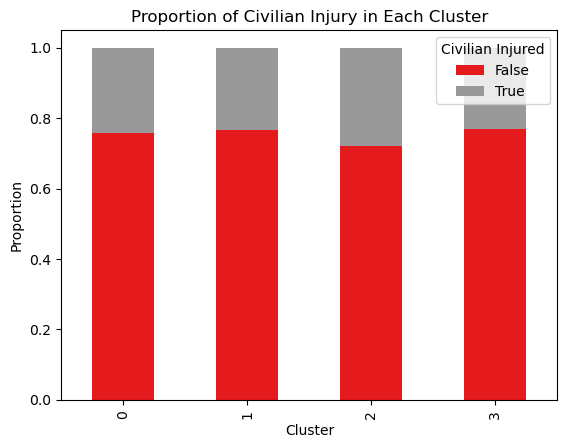

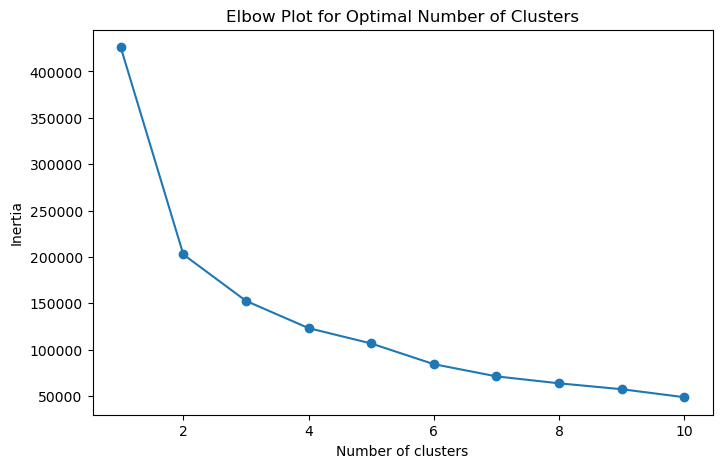

In [41]:
# Step 1: Define the features for clustering (excluding unit, year, and month)
features_for_clustering = ['Total_Population', 'Poverty_Percent', 'Percent_NonHispanic_White',
                           'Percent_NonHispanic_Black', 'Percent_NonHispanic_Asian', 'Percent_Hispanic']

# Step 2: Filter for the features and district identifier
df_filtered = merged_df[['district_numeric', 'civilian_injured'] + features_for_clustering].copy()

# Step 3: Fill missing values (median imputation)
df_filtered[features_for_clustering] = df_filtered[features_for_clustering].fillna(df_filtered[features_for_clustering].median())

# Step 4: Scale the features
scaler = StandardScaler()
df_filtered[features_for_clustering] = scaler.fit_transform(df_filtered[features_for_clustering])

# Step 5: Apply KMeans Clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=91)
df_filtered['cluster'] = kmeans.fit_predict(df_filtered[features_for_clustering])

# Step 6: Append cluster labels to the original dataframe
merged_df['cluster'] = df_filtered['cluster']

# Step 7: Show unique districts in each cluster
unique_districts_in_clusters = merged_df[['district_numeric', 'cluster']].drop_duplicates()
districts_in_clusters = unique_districts_in_clusters.groupby('cluster')['district_numeric'].apply(list)
print("Unique Districts in Each Cluster:")
print(districts_in_clusters)

# Step 8: Calculate and show the socio-demographic composition (mean values) for each cluster
cluster_profiles = merged_df.groupby('cluster')[features_for_clustering].mean()
print("Socio-Demographic Composition (Means) for Each Cluster:")
print(cluster_profiles)

# Step 9: Analyze how well clusters distinguish civilian injury
# Calculate the proportion of civilian injuries in each cluster
injury_distribution = merged_df.groupby('cluster')['civilian_injured'].value_counts(normalize=True).unstack()
print("Injury Distribution Across Clusters:")
print(injury_distribution)

# Plot civilian injury distribution across clusters
plt.figure(figsize=(10, 6))
injury_distribution.plot(kind='bar', stacked=True, colormap='Set1')
plt.title('Proportion of Civilian Injury in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Civilian Injured', loc='upper right')
plt.show()

# Step 10: Plot the elbow curve to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=91)
    model.fit(df_filtered[features_for_clustering])
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Step 5. Define features for final model 
Rank, duty_status, in_uniform were dropped due to low predictive value

In [43]:
# Define the features you want to use for modeling (including the new ones)
features_for_model = ['weapons_discharged', 'party_fired_first', 'gender', 'race',
    'civilian_gender', 'civilian_race', 'civilian_armed', 'inside','civilian_age', 'subject_resistance', 'member_action_severity',
    'cluster', 'experience_months', 'time_of_day', 'doj_decision', 'cumulative_force', 'year', 'Total_Population', 'Poverty_Percent', 'Percent_NonHispanic_White',
       'Percent_NonHispanic_Black', 'Percent_NonHispanic_Asian',
       'Percent_Hispanic', 'Violent Crime_rate_lag1',
       'Property Crime_rate_lag1', 'Drug-Related Crime_rate_lag1',
       'total_crime_rate_lag1', 'Public Order Crime_rate_lag1', 'covid_dummy', 'month_sin', 'month_cos', 'is_weekend'
]

# Separate the target variable and features
target = 'civilian_injured'  # Your target variable
X = merged_df[features_for_model]
y = merged_df[target]



In [44]:
# One-hot encode the selected categorical columns
categorical_features = ['party_fired_first', 'race', 'civilian_race', 'subject_resistance', 'member_action_severity', 'year', 'cluster',
       'time_of_day'] 


In [45]:
# Define binary columns (already in 0/1 format) 
binary_columns = ['inside', 'doj_decision', 'weapons_discharged', 'covid_dummy', 'is_weekend',
               'gender', 'civilian_gender', 'civilian_armed', 'month_sin', 'month_cos']

In [46]:
# Standardize numerical columns
numerical_features = ['Total_Population', 'Poverty_Percent', 'Percent_NonHispanic_White', 'civilian_age', 'experience_months', 'cumulative_force',
       'Percent_NonHispanic_Black', 'Percent_NonHispanic_Asian',
       'Percent_Hispanic', 'Violent Crime_rate_lag1',
       'Property Crime_rate_lag1', 'Drug-Related Crime_rate_lag1',
       'total_crime_rate_lag1', 'Public Order Crime_rate_lag1'
]


## Step 6. XGBClassifier Preprocessing and Modelling Pipeline

In [49]:
# Preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    remainder='passthrough'  # Pass through binary columns
)

# Define Pipeline
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=91)

pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])

# Hyperparameter grid
param_grid = {
    'xgb__n_estimators': [100, 150, 200, 300],
    'xgb__max_depth': [6, 7, 8, 9],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'xgb__gamma': [0, 0.01, 0.1, 0.3]
}

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, 
                                   n_iter=20, scoring='roc_auc', cv=tscv, verbose=1, 
                                   n_jobs=-1, random_state=91)

# Fit RandomizedSearchCV
random_search.fit(X, y)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Update the pipeline with the best parameters
pipeline.set_params(**best_params)

# Assign this pipeline as final model
final_pipeline = pipeline

# Define function to plot ROC-AUC and Precision-Recall curves
def plot_roc_and_pr_curves(y_test, y_proba, fold=None):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve' + (f' - Fold {fold}' if fold else ''))
    plt.legend(loc='best')

    # Precision-Recall Curve
    precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recalls, precisions)
    plt.subplot(1, 2, 2)
    plt.plot(recalls, precisions, color='g', label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve' + (f' - Fold {fold}' if fold else ''))
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Define evaluation function to collect metrics across folds
def evaluate_model_with_thresholds(X, y, final_pipeline, tscv, thresholds_to_try=[0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.4]):
    fold_metrics = []
    all_y_test = []
    all_y_proba = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
        print(f"\n---- Fold {fold} ----")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Preprocess the data
        X_train_preprocessed = final_pipeline.named_steps['preprocessor'].fit_transform(X_train)
        X_test_preprocessed = final_pipeline.named_steps['preprocessor'].transform(X_test)
        
        # Apply SMOTE and Under-sampling on preprocessed data
        over = BorderlineSMOTE(sampling_strategy=0.6, k_neighbors=6, m_neighbors=15, random_state=91)
        under = RandomUnderSampler(sampling_strategy=0.68, random_state=91)
        X_train_resampled, y_train_resampled = over.fit_resample(X_train_preprocessed, y_train)
        X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

        # Fit the model
        final_pipeline.named_steps['xgb'].fit(X_train_resampled, y_train_resampled)

        # Predictions
        y_proba = final_pipeline.named_steps['xgb'].predict_proba(X_test_preprocessed)[:, 1]

        # Collect all test labels and probabilities for aggregate plotting
        all_y_test.extend(y_test)
        all_y_proba.extend(y_proba)

        # Plot ROC and Precision-Recall curves for the fold
        print(f"Plotting ROC and Precision-Recall curves for Fold {fold}")
        plot_roc_and_pr_curves(y_test, y_proba, fold=fold)

        # Evaluate model performance for different thresholds
        for threshold in thresholds_to_try:
            y_pred = (y_proba >= threshold).astype(int)

            # Calculate the metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)

            # Append results to fold_metrics
            fold_metrics.append({
                'fold': fold,
                'threshold': threshold,
                'roc_auc': roc_auc,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy
            })

            # Print the results for each fold and threshold
            print(f"\nThreshold: {threshold}")
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-score: {f1:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
        
    # After all folds, plot aggregated ROC and Precision-Recall curves
    print("\nPlotting aggregated ROC and Precision-Recall curves across all folds")
    plot_roc_and_pr_curves(all_y_test, all_y_proba)
    
    return pd.DataFrame(fold_metrics)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'xgb__subsample': 0.6, 'xgb__n_estimators': 200, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__colsample_bytree': 0.6}



---- Fold 1 ----
Plotting ROC and Precision-Recall curves for Fold 1


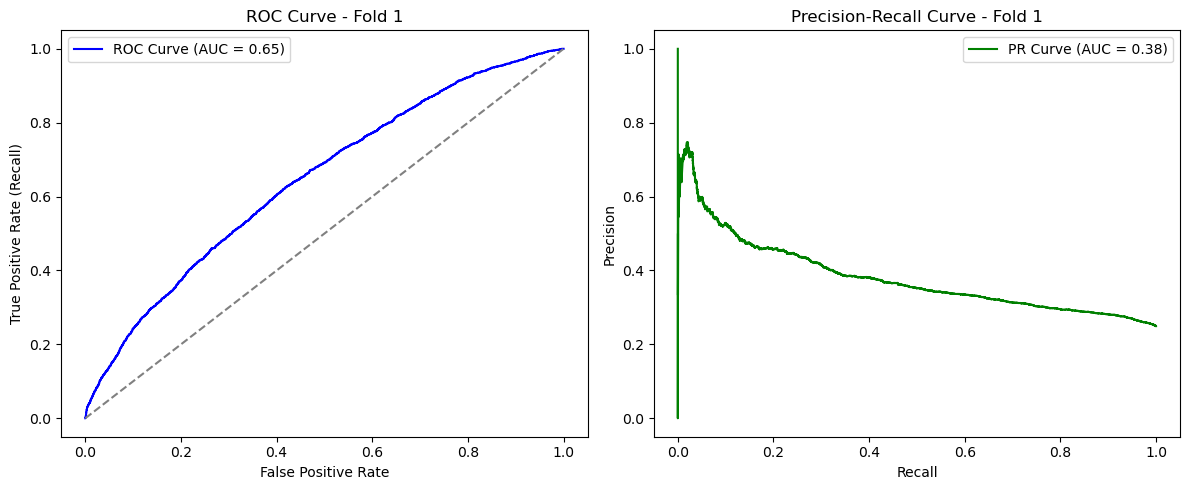


Threshold: 0.32
ROC AUC: 0.6450
Precision: 0.2942
Recall: 0.8110
F1-score: 0.4318
Accuracy: 0.4677

Threshold: 0.33
ROC AUC: 0.6450
Precision: 0.2979
Recall: 0.7873
F1-score: 0.4323
Accuracy: 0.4842

Threshold: 0.34
ROC AUC: 0.6450
Precision: 0.3024
Recall: 0.7608
F1-score: 0.4328
Accuracy: 0.5026

Threshold: 0.35
ROC AUC: 0.6450
Precision: 0.3100
Recall: 0.7283
F1-score: 0.4349
Accuracy: 0.5279

Threshold: 0.36
ROC AUC: 0.6450
Precision: 0.3176
Recall: 0.6829
F1-score: 0.4335
Accuracy: 0.5550

Threshold: 0.37
ROC AUC: 0.6450
Precision: 0.3307
Recall: 0.6287
F1-score: 0.4334
Accuracy: 0.5901

Threshold: 0.38
ROC AUC: 0.6450
Precision: 0.3405
Recall: 0.5596
F1-score: 0.4234
Accuracy: 0.6199

Threshold: 0.4
ROC AUC: 0.6450
Precision: 0.3663
Recall: 0.4441
F1-score: 0.4015
Accuracy: 0.6698

---- Fold 2 ----
Plotting ROC and Precision-Recall curves for Fold 2


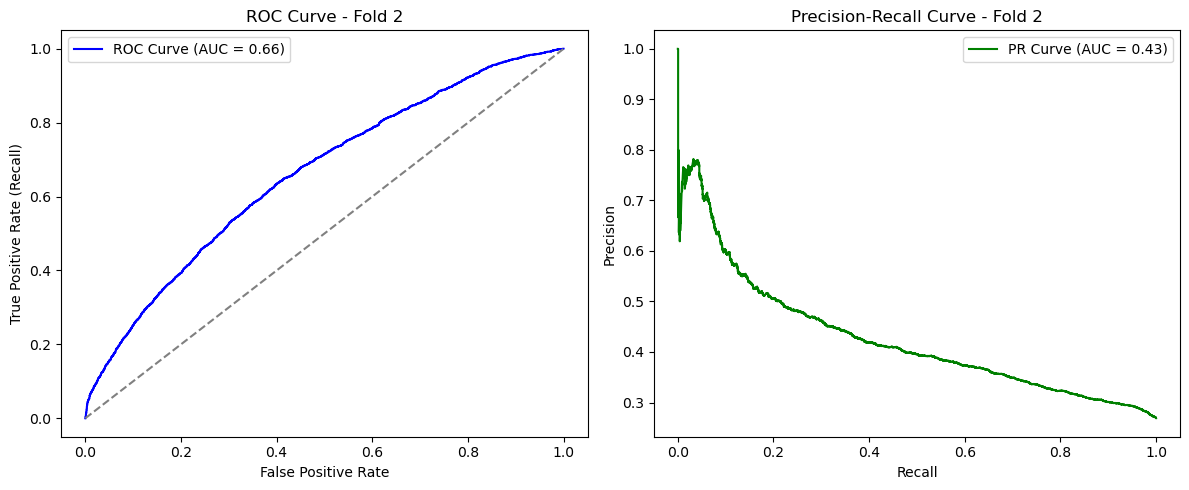


Threshold: 0.32
ROC AUC: 0.6595
Precision: 0.3131
Recall: 0.8457
F1-score: 0.4570
Accuracy: 0.4597

Threshold: 0.33
ROC AUC: 0.6595
Precision: 0.3171
Recall: 0.8247
F1-score: 0.4581
Accuracy: 0.4753

Threshold: 0.34
ROC AUC: 0.6595
Precision: 0.3231
Recall: 0.7926
F1-score: 0.4591
Accuracy: 0.4977

Threshold: 0.35
ROC AUC: 0.6595
Precision: 0.3337
Recall: 0.7549
F1-score: 0.4628
Accuracy: 0.5288

Threshold: 0.36
ROC AUC: 0.6595
Precision: 0.3469
Recall: 0.7069
F1-score: 0.4654
Accuracy: 0.5633

Threshold: 0.37
ROC AUC: 0.6595
Precision: 0.3632
Recall: 0.6510
F1-score: 0.4662
Accuracy: 0.5992

Threshold: 0.38
ROC AUC: 0.6595
Precision: 0.3804
Recall: 0.5768
F1-score: 0.4584
Accuracy: 0.6335

Threshold: 0.4
ROC AUC: 0.6595
Precision: 0.4137
Recall: 0.4166
F1-score: 0.4152
Accuracy: 0.6844

---- Fold 3 ----
Plotting ROC and Precision-Recall curves for Fold 3


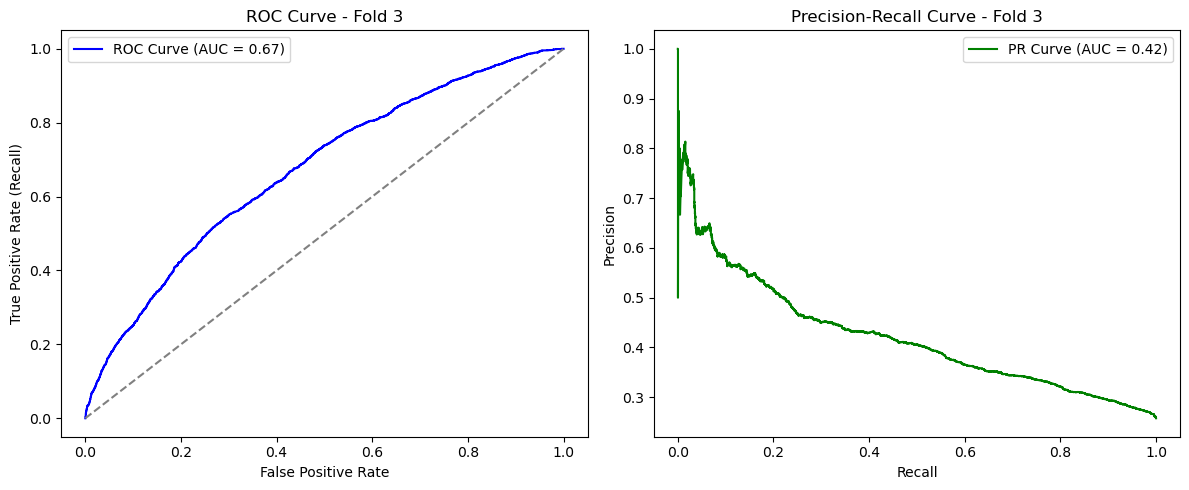


Threshold: 0.32
ROC AUC: 0.6720
Precision: 0.3097
Recall: 0.8414
F1-score: 0.4528
Accuracy: 0.4756

Threshold: 0.33
ROC AUC: 0.6720
Precision: 0.3148
Recall: 0.8145
F1-score: 0.4541
Accuracy: 0.4950

Threshold: 0.34
ROC AUC: 0.6720
Precision: 0.3277
Recall: 0.7801
F1-score: 0.4615
Accuracy: 0.5306

Threshold: 0.35
ROC AUC: 0.6720
Precision: 0.3390
Recall: 0.7392
F1-score: 0.4649
Accuracy: 0.5612

Threshold: 0.36
ROC AUC: 0.6720
Precision: 0.3442
Recall: 0.7018
F1-score: 0.4619
Accuracy: 0.5784

Threshold: 0.37
ROC AUC: 0.6720
Precision: 0.3522
Recall: 0.6602
F1-score: 0.4594
Accuracy: 0.5993

Threshold: 0.38
ROC AUC: 0.6720
Precision: 0.3733
Recall: 0.5803
F1-score: 0.4543
Accuracy: 0.6406

Threshold: 0.4
ROC AUC: 0.6720
Precision: 0.4168
Recall: 0.4512
F1-score: 0.4333
Accuracy: 0.6957

---- Fold 4 ----
Plotting ROC and Precision-Recall curves for Fold 4


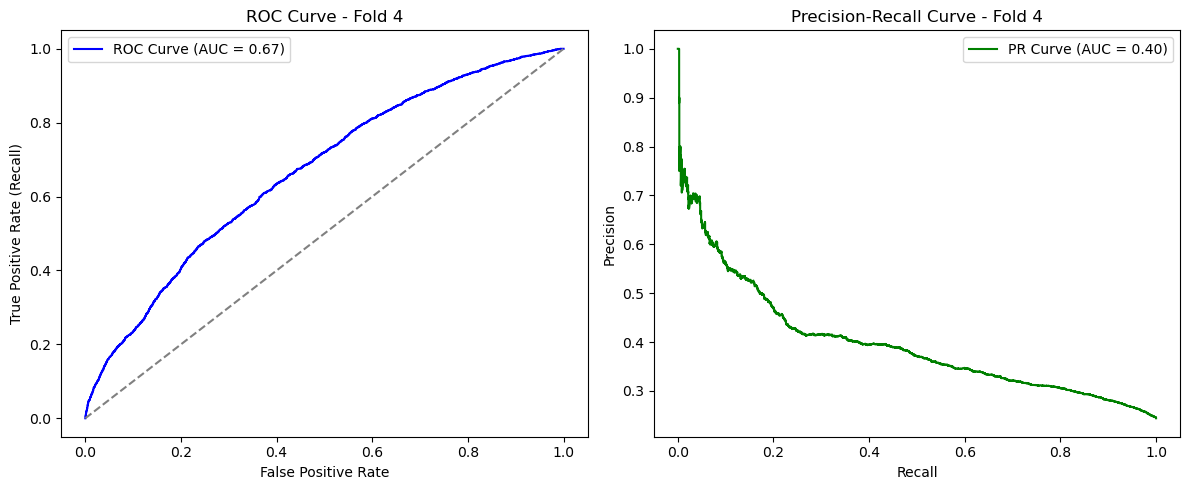


Threshold: 0.32
ROC AUC: 0.6657
Precision: 0.2992
Recall: 0.8291
F1-score: 0.4397
Accuracy: 0.4839

Threshold: 0.33
ROC AUC: 0.6657
Precision: 0.3085
Recall: 0.7890
F1-score: 0.4435
Accuracy: 0.5164

Threshold: 0.34
ROC AUC: 0.6657
Precision: 0.3159
Recall: 0.7312
F1-score: 0.4412
Accuracy: 0.5475

Threshold: 0.35
ROC AUC: 0.6657
Precision: 0.3211
Recall: 0.6939
F1-score: 0.4390
Accuracy: 0.5669

Threshold: 0.36
ROC AUC: 0.6657
Precision: 0.3323
Recall: 0.6610
F1-score: 0.4423
Accuracy: 0.5929

Threshold: 0.37
ROC AUC: 0.6657
Precision: 0.3521
Recall: 0.5659
F1-score: 0.4341
Accuracy: 0.6396

Threshold: 0.38
ROC AUC: 0.6657
Precision: 0.3796
Recall: 0.4846
F1-score: 0.4257
Accuracy: 0.6807

Threshold: 0.4
ROC AUC: 0.6657
Precision: 0.3959
Recall: 0.4210
F1-score: 0.4080
Accuracy: 0.7017

---- Fold 5 ----
Plotting ROC and Precision-Recall curves for Fold 5


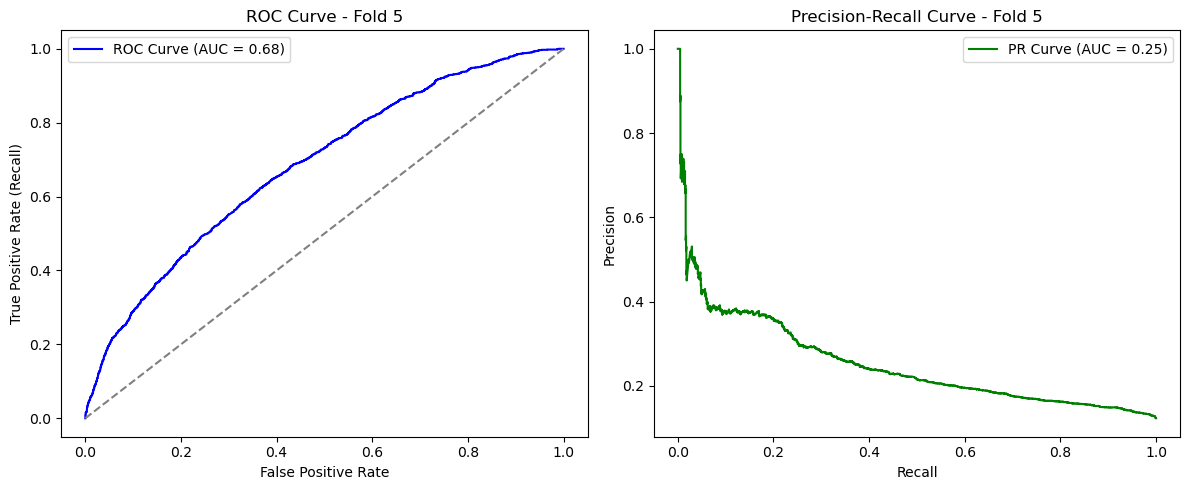


Threshold: 0.32
ROC AUC: 0.6831
Precision: 0.1544
Recall: 0.8648
F1-score: 0.2620
Accuracy: 0.4003

Threshold: 0.33
ROC AUC: 0.6831
Precision: 0.1579
Recall: 0.8353
F1-score: 0.2656
Accuracy: 0.4314

Threshold: 0.34
ROC AUC: 0.6831
Precision: 0.1641
Recall: 0.7838
F1-score: 0.2714
Accuracy: 0.4820

Threshold: 0.35
ROC AUC: 0.6831
Precision: 0.1722
Recall: 0.7200
F1-score: 0.2779
Accuracy: 0.5394

Threshold: 0.36
ROC AUC: 0.6831
Precision: 0.1844
Recall: 0.6630
F1-score: 0.2885
Accuracy: 0.5975

Threshold: 0.37
ROC AUC: 0.6831
Precision: 0.1995
Recall: 0.5841
F1-score: 0.2974
Accuracy: 0.6604

Threshold: 0.38
ROC AUC: 0.6831
Precision: 0.2203
Recall: 0.4949
F1-score: 0.3049
Accuracy: 0.7222

Threshold: 0.4
ROC AUC: 0.6831
Precision: 0.2397
Recall: 0.4001
F1-score: 0.2998
Accuracy: 0.7700

Plotting aggregated ROC and Precision-Recall curves across all folds


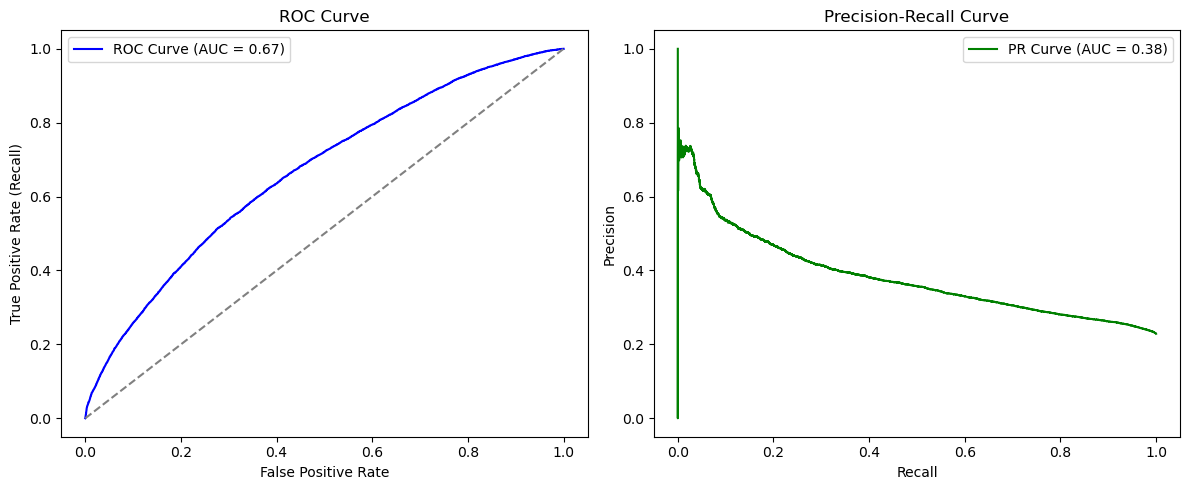

In [54]:
# Evaluate the model and collect metrics across folds
metrics_df = evaluate_model_with_thresholds(X, y, pipeline, tscv)


In [55]:
# Average and individual for different thresholds [ignore fold column, not relevant]
print("\nAverage Metrics Across Folds:")
average_metrics = metrics_df.groupby('threshold').mean()
print(average_metrics)



Average Metrics Across Folds:
           fold   roc_auc  precision    recall        f1  accuracy
threshold                                                         
0.32        3.0  0.665074   0.274126  0.838410  0.408658  0.457430
0.33        3.0  0.665074   0.279228  0.810157  0.410702  0.480476
0.34        3.0  0.665074   0.286626  0.769734  0.413182  0.512089
0.35        3.0  0.665074   0.295190  0.727261  0.415889  0.544834
0.36        3.0  0.665074   0.305084  0.683133  0.418336  0.577410
0.37        3.0  0.665074   0.319541  0.617976  0.418114  0.617724
0.38        3.0  0.665074   0.338816  0.539234  0.413352  0.659390
0.40        3.0  0.665074   0.366484  0.426594  0.391556  0.704300


## Step 7.  Extract Final Model Metrics for chosen Threshold (0.35)


Final Evaluation on Full Data at Threshold 0.35
Final ROC AUC: 0.7072
Final Accuracy: 0.5579
Precision (Injured): 0.3236
Recall (Injured): 0.7795
F1-score (Injured): 0.4574

Plotting ROC and Precision-Recall curves on Full Data


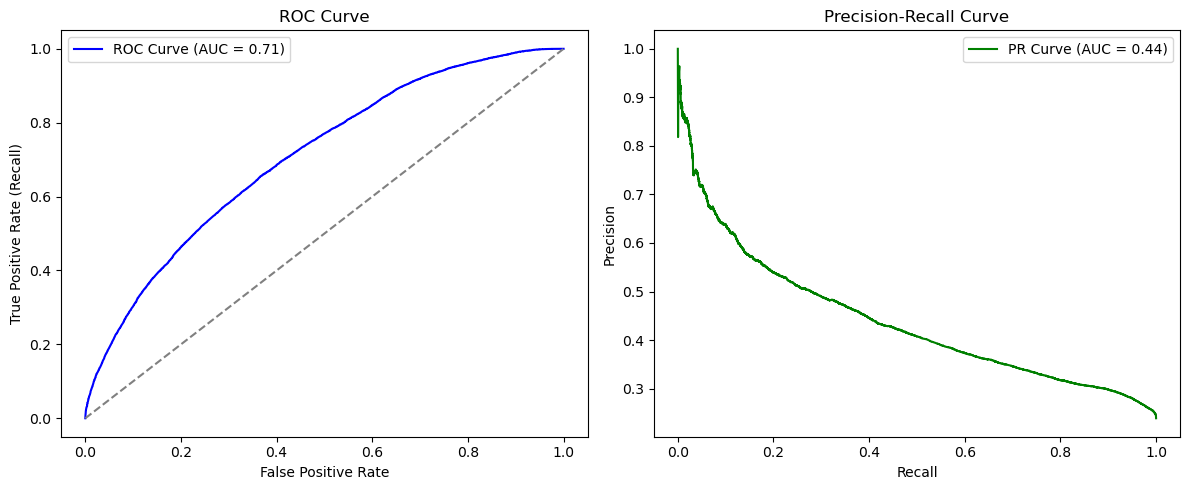

In [57]:
#Fiinal threshold and evaluate final metrics
final_threshold = 0.35  # Set based on evaluation of recall and f1
X_preprocessed = pipeline.named_steps['preprocessor'].fit_transform(X)  # Fit on full data

# Apply SMOTE and Under-sampling on full data
over = BorderlineSMOTE(sampling_strategy=0.6, k_neighbors=6, m_neighbors=15, random_state=91)
under = RandomUnderSampler(sampling_strategy=0.68, random_state=91)
X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Retrain the model on full resampled data
pipeline.named_steps['xgb'].fit(X_resampled, y_resampled)

# Use the pipeline to make predictions on the original data
y_proba = pipeline.named_steps['xgb'].predict_proba(X_preprocessed)[:, 1]
y_pred = (y_proba >= final_threshold).astype(int)

# Final evaluation
roc_auc = roc_auc_score(y, y_proba)
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred, target_names=['False', 'True'], output_dict=True)

# Extract final metrics for positive class (Injured)
precision_injured = report['True']['precision']
recall_injured = report['True']['recall']
f1_injured = report['True']['f1-score']

# Print out final metrics
print(f"\nFinal Evaluation on Full Data at Threshold {final_threshold}")
print(f"Final ROC AUC: {roc_auc:.4f}")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Precision (Injured): {precision_injured:.4f}")
print(f"Recall (Injured): {recall_injured:.4f}")
print(f"F1-score (Injured): {f1_injured:.4f}")

# Plot ROC and Precision-Recall curves on full data
print("\nPlotting ROC and Precision-Recall curves on Full Data")
plot_roc_and_pr_curves(y, y_proba)

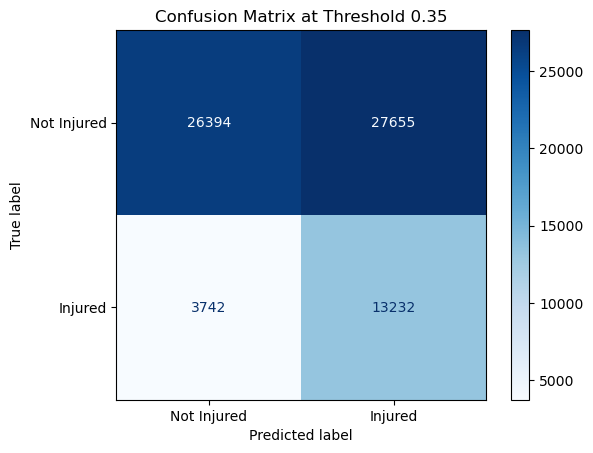

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get confusion matrix at threshold 0.35
y_pred_final = (y_proba >= 0.35).astype(int)
cm = confusion_matrix(y, y_pred_final)

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Injured', 'Injured']).plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix at Threshold 0.35")
plt.show()

## Step 8. Save the trained final XGBoost Model

In [60]:
# Save the final pipeline (this includes preprocessing steps and the trained XGBoost model)
joblib.dump(final_pipeline, 'final_xgboost_pipeline.pkl')

# To load if necessary
#final_model = joblib.load('final_xgboost_pipeline.pkl')


['final_xgboost_pipeline.pkl']

## Step 9. Feature Importance- Global XGBoost

In [62]:
# Extract feature importance from the XGBoost model
importances = final_pipeline.named_steps['xgb'].feature_importances_
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)

                                              Feature  Importance
65                         remainder__civilian_gender    0.120248
34  onehotencoder__member_action_severity_Emergenc...    0.084237
33  onehotencoder__member_action_severity_Control ...    0.061481
38  onehotencoder__member_action_severity_Physical...    0.054408
68                            remainder__doj_decision    0.045586
64                                  remainder__gender    0.043216
39  onehotencoder__member_action_severity_Physical...    0.042660
24                 onehotencoder__civilian_race_Black    0.037698
66                          remainder__civilian_armed    0.029658
62               onehotencoder__time_of_day_Nighttime    0.028787
61                 onehotencoder__time_of_day_Daytime    0.027874
15        onehotencoder__party_fired_first_None Fired    0.023704
28  onehotencoder__subject_resistance_Active Resister    0.021910
55                           onehotencoder__year_2019    0.021883
35      on

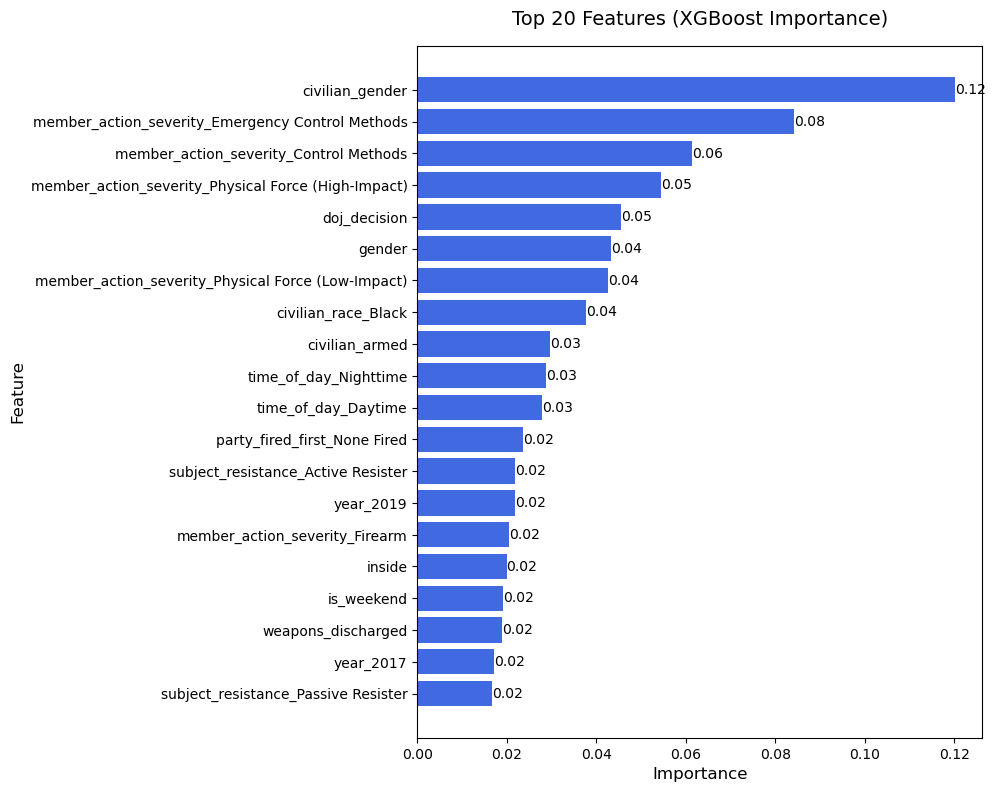

In [63]:
# Number of top features to display
top_n = 20

# Remove the "onehotencoder__", "standardscaler__", and "remainder__" prefixes
cleaned_feature_names = [name.replace('onehotencoder__', '').replace('standardscaler__', '').replace('remainder__', '') for name in feature_names]

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': cleaned_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select the top N most important features
top_feature_importance_df = feature_importance_df.head(top_n)

# Plot the top N feature importance with a compact layout
plt.figure(figsize=(10, 8))  # Adjust the figure size to be more compact
bars = plt.barh(top_feature_importance_df['Feature'], top_feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Features (XGBoost Importance)', fontsize=14, pad=15)

# Reduce the space between the bars
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.tight_layout(pad=1.0)  # Adjust layout to make it tighter

# Add value labels to each bar for better visualization
for bar in bars:
    plt.text(
        bar.get_width(),  # Position at the width of the bar
        bar.get_y() + bar.get_height()/2,  # Vertical alignment
        f'{bar.get_width():.2f}',  # Display the importance value rounded to 2 decimal places
        va='center',  # Center the text vertically
        ha='left',  # Position the text to the right of the bar
        fontsize=10  # Font size for the labels
    )
plt.savefig('xgboost_feature_importance.png', dpi=300)
plt.show()


## Step 10. Feature Importance - SHAP

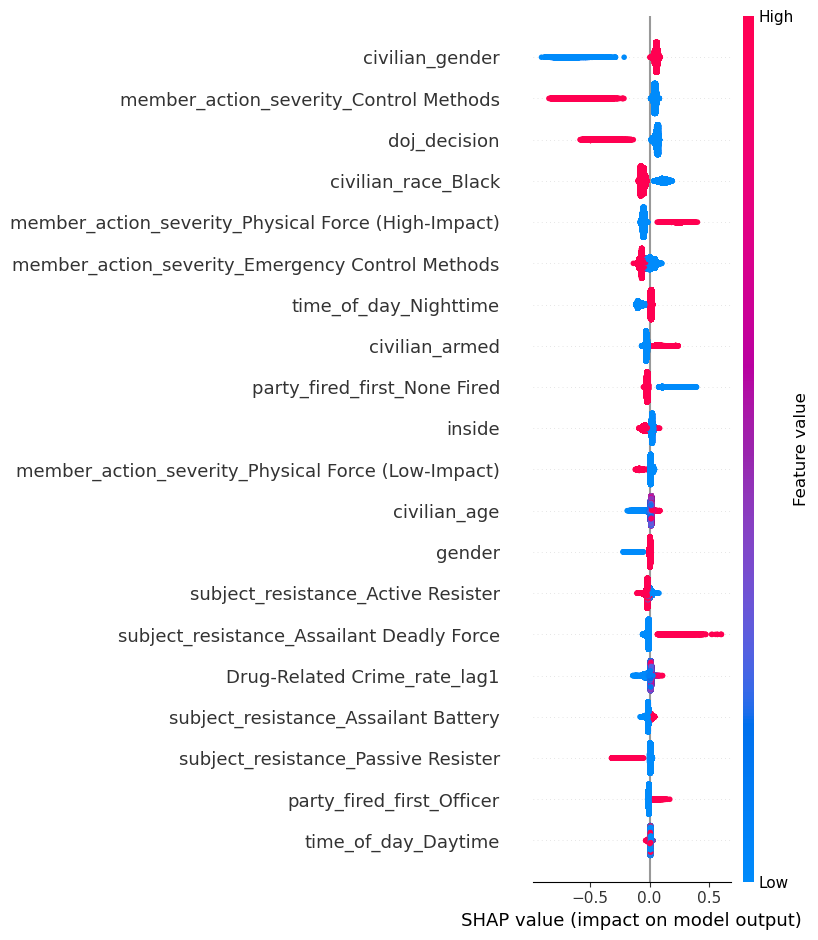

<Figure size 640x480 with 0 Axes>

In [70]:
# Extract SHAP values and feature names
# Create SHAP Explainer using the XGBoost model from the pipeline
explainer = shap.Explainer(final_pipeline.named_steps['xgb'])

# Extract SHAP values (assuming X_preprocessed is already preprocessed data)
shap_values = explainer(X_preprocessed)

# Get feature names from the preprocessor
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()


# Remove the "onehotencoder__" and "standardscaler__" prefixes
cleaned_feature_names = [name.replace('onehotencoder__', '').replace('standardscaler__', '').replace('remainder__', '') for name in feature_names]

# Plot SHAP summary plot with cleaned feature names
shap.summary_plot(shap_values.values, X_preprocessed, feature_names=cleaned_feature_names)
# Save the SHAP plot
plt.savefig('shap_summary_top_20.png', dpi=300)

## Step 11. Custom SHAP Visualisations
To narrow down on features by themes in the report, as the graphs showing all variables together are not easily digestible

In [72]:
cleaned_feature_names = [name.replace('onehotencoder__', '').replace('standardscaler__', '').replace('remainder__', '') for name in feature_names]


In [73]:
# Define feature categories
action_features = [
    'member_action_severity_Emergency Control Methods',
    'member_action_severity_Control Methods', 'member_action_severity_Impact Weapon', 'member_action_severity_Less-Lethal Weapon',
    'member_action_severity_Physical Force (High-Impact)',
    'member_action_severity_Physical Force (Low-Impact)',
    'member_action_severity_Firearm', 'subject_resistance_Passive Resister', 'subject_resistance_Active Resister', 'subject_resistance_Passive Resister', 'subject_resistance_Assailant Battery', 'subject_resistance_Assailant Deadly Force',
    'subject_resistance_Assailant Assault'
]

In [74]:
incident_features = [
   'time_of_day_Nighttime', 'time_of_day_Daytime', 'party_fired_first_None Fired', 'party_fired_first_Officer', 'party_fired_first_Other', 'party_fired_first_Civilian', 'civilian_armed',
    'weapons_discharged', 'inside', 'is_weekend'
]


In [75]:
crime_social_features = [
    'Total_Population', 'Poverty_Percent', 'Percent_NonHispanic_White', 
    'Percent_NonHispanic_Black', 'Percent_Hispanic',
    'Drug-Related Crime_rate_lag1', 'Property Crime_rate_lag1', 'total_crime_rate_lag1', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
]

In [76]:
temporal_features = [
    'year_2019', 'month_sin', 'month_cos', 'doj_decision', 'covid_dummy', 'is_weekend',  'year_2005', 'year_2006','year_2007', 'year_2008', 'year_2009', 
    'year_2010', 'year_2011', 'year_2012', 'year_2015', 'year_2013', 'year_2014', 'year_2016', 'year_2017', 'year_2018', 'year_2020']

In [77]:
officer_features = ['experience_months', 'race_White', 'race_Hispanic', 'race_Black', 'race_Asian', 'race_Native American','gender', 'cumulative_force']
civilian_features = ['civilian_age', 'civilian_gender', 'civilian_race', 'civilian_race_Black', 'civilian_race_White', 'civilian_race_Hispanic', 'civilian_race_Native American', 'civilian_race_Asian', 'civilian_armed']


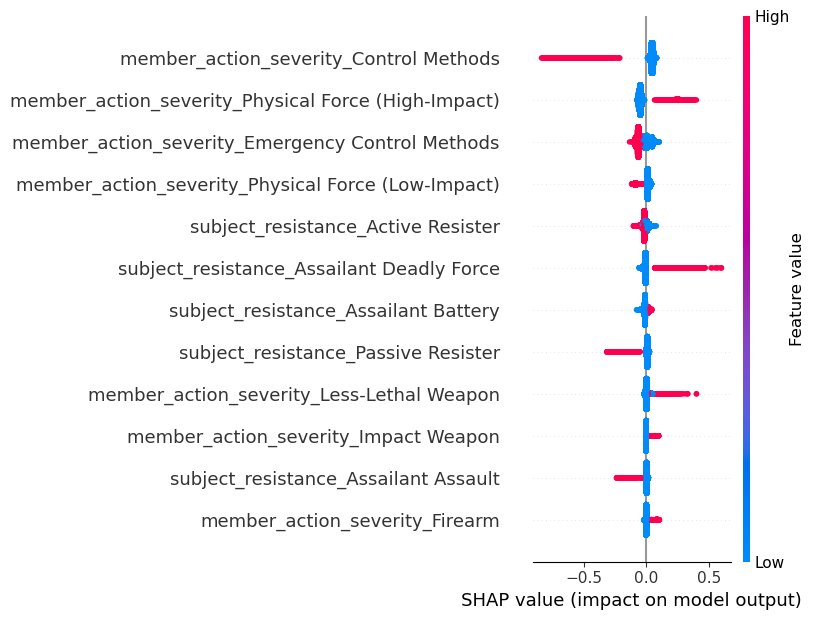

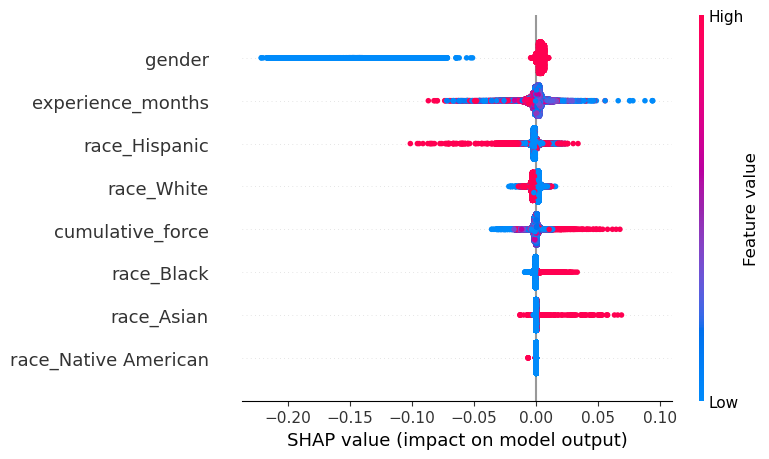

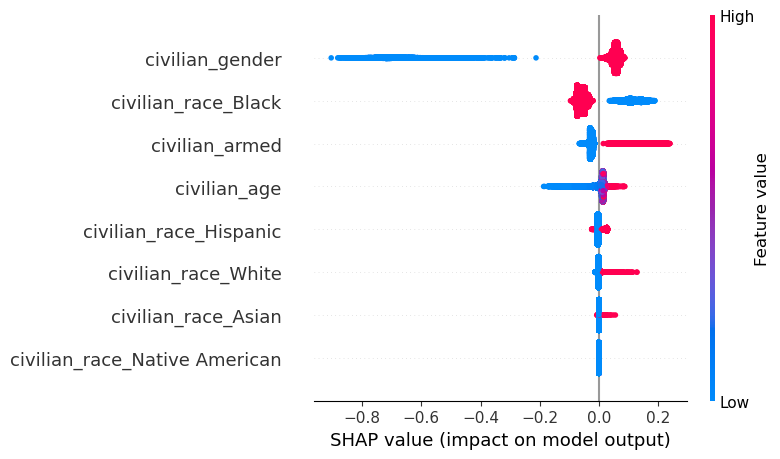

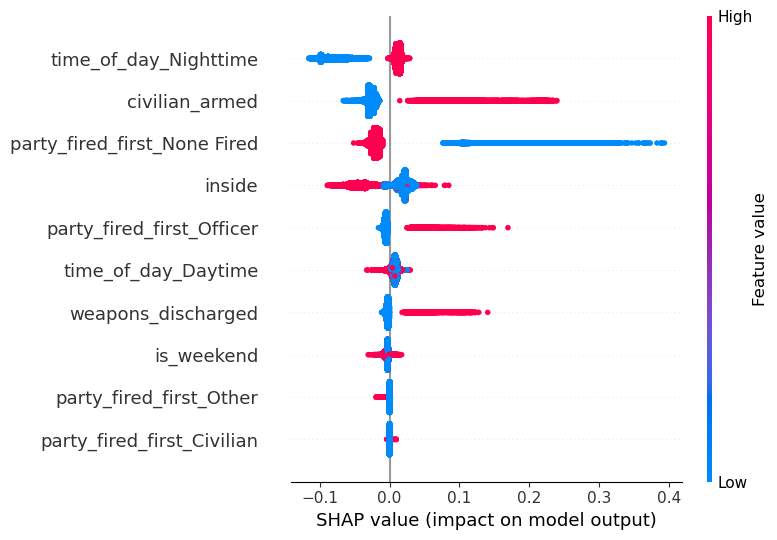

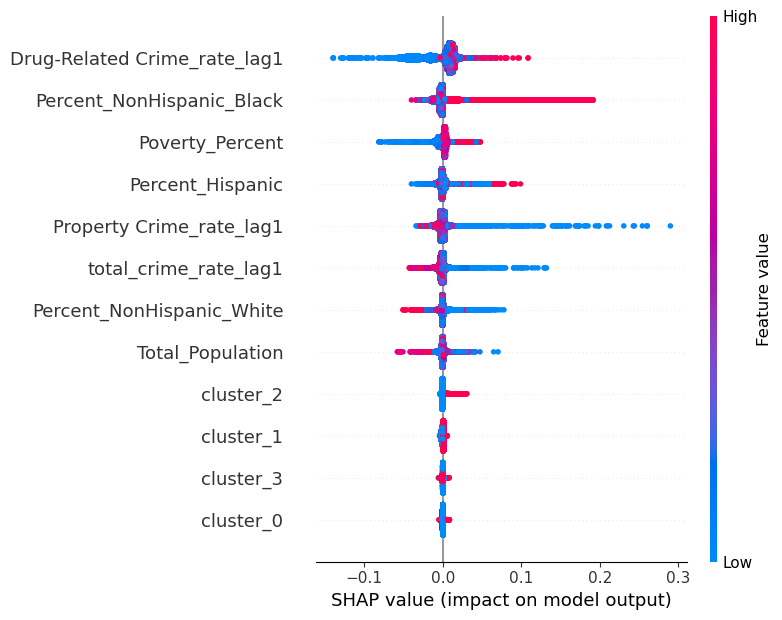

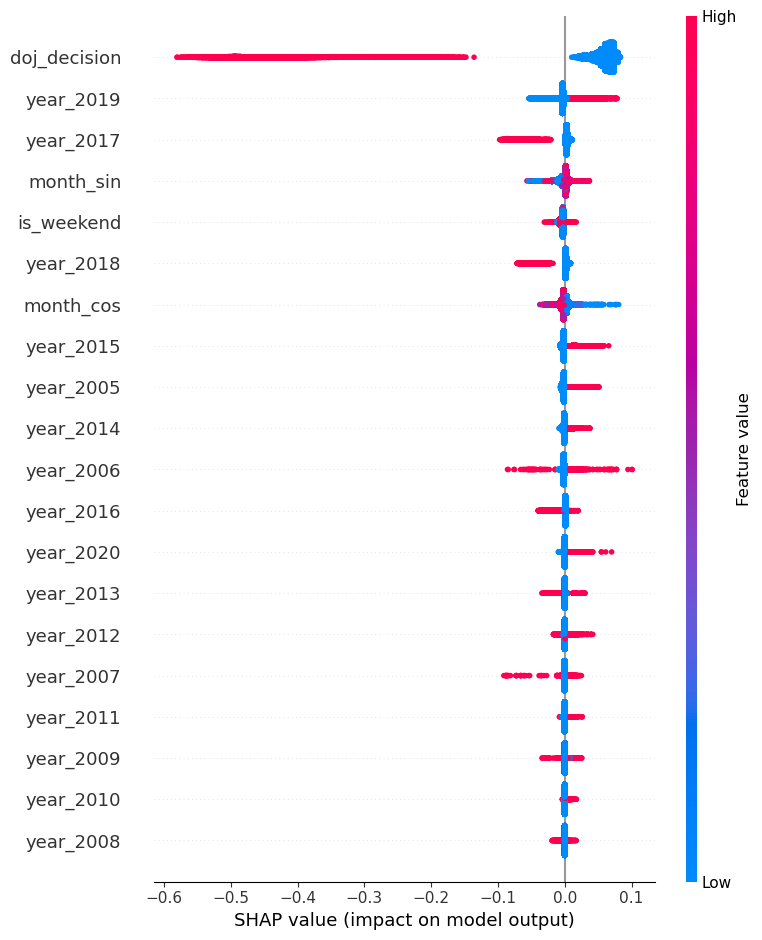

In [78]:
# Map feature names in cleaned format for SHAP visualization
def get_feature_indices(feature_names, cleaned_feature_names):
    return [i for i, feature in enumerate(cleaned_feature_names) if feature in feature_names]

# Create function to plot SHAP values for any feature category
def plot_shap_by_category(shap_values, X_preprocessed, feature_names, category_features, category_name):
    category_indices = get_feature_indices(category_features, feature_names)
    
    shap.summary_plot(
        shap_values[:, category_indices], 
        X_preprocessed[:, category_indices],
        feature_names=[feature_names[i] for i in category_indices],
        plot_type="dot",  # Use "dot" for showing direction of influence
        title=f"SHAP Summary for {category_name}"
    )

# Example usage for SHAP values
plot_shap_by_category(shap_values, X_preprocessed, cleaned_feature_names, action_features, "Action Characteristics")
plot_shap_by_category(shap_values, X_preprocessed, cleaned_feature_names, officer_features, "Officer Characteristics")
plot_shap_by_category(shap_values, X_preprocessed, cleaned_feature_names, civilian_features, "Civilian Characteristics")
plot_shap_by_category(shap_values, X_preprocessed, cleaned_feature_names, incident_features, "Incident-Related Variables")
plot_shap_by_category(shap_values, X_preprocessed, cleaned_feature_names, crime_social_features, "Crime and Social Demographics")
plot_shap_by_category(shap_values, X_preprocessed, cleaned_feature_names, temporal_features, "Temporal Variables")